IMPORTING LIBRARIES INTO THE NOTE BOOK

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from dash import Dash, dcc, html, Input, Output #Incase you don't have dash run cell two
import dash.exceptions

In [2]:
pip install dash

Note: you may need to restart the kernel to use updated packages.


**Data Preparation**

In [3]:
# Data wrangling
def wrangle():

  # Importing Data from the Google drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  # Set the search parameters
  filename = 'Okello_Daniel_Chris.xlsx'
  search_path = '/content/drive/My Drive'

  # Search for the file
  for root, dirs, files in os.walk(search_path):
      if filename in files:
          file_path = os.path.join(root, filename)
          break

  return df

In [ ]:
df = wrangle()

In [109]:
df.head()

,OBS#,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIO,EDUCATION,RETRAINING,...,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,1,0,6,4,0,0,0,1,0,0,...,67,0,0,1,2,2,1,1,0,1
1,2,1,48,2,0,0,0,1,0,0,...,22,0,0,1,1,2,1,0,0,0
2,3,3,12,4,0,0,0,0,1,0,...,49,0,0,1,1,1,2,0,0,1
3,4,0,42,2,0,0,1,0,0,0,...,45,0,0,0,1,2,2,0,0,1
4,5,0,24,3,1,0,0,0,0,0,...,53,0,0,0,2,2,2,0,0,0


**Exploratory Data Analysis**

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   OBS#              1000 non-null   int64
 1   CHK_ACCT          1000 non-null   int64
 2   DURATION          1000 non-null   int64
 3   HISTORY           1000 non-null   int64
 4   NEW_CAR           1000 non-null   int64
 5   USED_CAR          1000 non-null   int64
 6   FURNITURE         1000 non-null   int64
 7   RADIO             1000 non-null   int64
 8   EDUCATION         1000 non-null   int64
 9   RETRAINING        1000 non-null   int64
 10  AMOUNT            1000 non-null   int64
 11  SAV_ACCT          1000 non-null   int64
 12  EMPLOYMENT        1000 non-null   int64
 13  INSTALL_RATE      1000 non-null   int64
 14  MALE_DIV          1000 non-null   int64
 15  MALE_SINGLE       1000 non-null   int64
 16  MALE_MAR_or_WID   1000 non-null   int64
 17  CO-APPLICANT      1000 non-null   

In [54]:
# check for repeated values
df.duplicated().sum()

0

There are no dublicate variables.

In [57]:
# Descriptive Summaries for Numerical Variables
numerical_variables =['DURATION', 'AMOUNT', 'INSTALL_RATE', 'AGE', 'NUM_CREDITS', 'NUM_DEPENDENTS']
df[numerical_variables].describe()

,DURATION,AMOUNT,INSTALL_RATE,AGE,NUM_CREDITS,NUM_DEPENDENTS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,75.000000,4.000000,2.000000


In [58]:
df[numerical_variables].skew()

DURATION          1.094184
AMOUNT            1.949628
INSTALL_RATE     -0.531348
AGE               1.020739
NUM_CREDITS       1.272576
NUM_DEPENDENTS    1.909445
dtype: float64

Most of the numerical variables exhibit a moderate positive skewness.

In [43]:
def response_plot():
    # Assigning categories to their responding names
    Response_dict = {
        0: "No",
        1: "Yes",
    }

    Response_cl = df["RESPONSE"].replace(Response_dict)

    # Calculate relative frequencies
    response_counts = Response_cl.value_counts(normalize=True).reset_index()
    response_counts.columns = ["Response", "Relative Frequency"]

    # Create a bar chart using Plotly Express
    fig = px.bar(response_counts, x="Response", y="Relative Frequency",
                 color="Response", title="Credit Rating")

    # Show the plot
    return fig.show()

In [44]:
response_plot()

Basing on the graph above, the majority of the clients (70%) have good credit records.
NB: Because of this imbalance arrangement, we need to resample our observations when building the model

In [70]:
def doughnut_chart_employ_since():
    employ_since_dict = {
        0: "unemployed",
        1: "< 1 year",
        2: "1 <= ... < 4 years",
        3: "4 <=... < 7 years",
        4: ">= 7 years"
    }

    employ_since_cl = df["EMPLOYMENT"].replace(employ_since_dict).sort_values()

    # Data
    employ_since_counts = employ_since_cl.value_counts(normalize=True).reset_index()
    employ_since_counts.columns = ["Years of Employment", "Percentage"]

    # Create a donut chart using Plotly Express
    fig = px.pie(
        employ_since_counts,
        values="Percentage",
        names="Years of Employment",
        color_discrete_sequence=['red', 'green', 'skyblue', 'gold', 'brown'],
        hole=0.5,
        title="Doughnut showing the distribution of Customers based on years of employment"
    )

    # Update layout for a better appearance
    fig.update_traces(textinfo="percent+label", pull=[0, 0.2, 0, 0, 0], textposition="inside", insidetextorientation="radial")

    return fig

In [71]:
doughnut_chart_employ_since()

Basing on the graph above, the majority of the clients served worked for a period of 1 to 4 years, followed by more than 7 years, and there are few clients who are unemployed.

In [47]:
def histogram_age():
    # Create a histogram using Plotly Express
    fig = px.histogram(x=df["AGE"], nbins=10, title="Age Distribution")

    # Update x and y axis labels
    fig.update_xaxes(title="Age")
    fig.update_yaxes(title="Frequency (count)")

    # Show the plot
    return fig

In [48]:
histogram_age()

The majority of the clients are between 29 to 40 years

In [49]:
def horizontal_chart_status():
    status_dict = {
       0: "< 0 DM",
       1: "0 < ...< 200 DM",
       2: ">= 200 DM",
       3: "no checking account"
    }

    status_cl = df["CHK_ACCT"].replace(status_dict)

    # Calculate value counts
    status_counts = status_cl.value_counts()

    # Create a horizontal bar chart using Plotly
    fig = go.Figure(go.Bar(
        y=status_counts.index,
        x=status_counts.values,
        orientation='h',
        marker_color='blue'
    ))
    fig.update_layout(
        title='Horizontal Bar Chart for CHK Status',
        xaxis_title='Frequency',
        yaxis_title='CHK Status'
    )

    return fig

In [50]:
horizontal_chart_status()

Since there are no missing values and also the outliers and multicollinearity does not affect the ensemble models, there is no need of removing the outliers and correlated variables
. The essential thing is standardization of our numerical data and building our model

**Normalization of Variables**

In [64]:
def normalize_one(selected_features_copy, feature):
    mean_values = np.mean(selected_features_copy[feature])
    std_devs = np.std(selected_features_copy[feature])
    selected_features_copy[feature] = (selected_features_copy[feature] - mean_values) / std_devs
    return selected_features_copy

In [60]:
def selected_var(df):
    # Your feature selection logic here
    selected_features = df[["AMOUNT", "CHK_ACCT", "AGE", "SAV_ACCT", "DURATION",
                            "HISTORY", "EMPLOYMENT", "OTHER_INSTALL", "INSTALL_RATE", "PROP_UNKN_NONE",
                            "NUM_DEPENDENTS", "REAL_ESTATE", "JOB"]]

    selected_features_copy = selected_features.copy()

    # Standardization of each selected continuos variable
    features_to_normalize = list(("AGE", "AMOUNT", "DURATION"))

    for feature in features_to_normalize:
            normalize_one(selected_features_copy=selected_features_copy, feature=feature)

    return selected_features_copy

**MODEL DEVELOPMENT**

**Splitting the Dataset**

In [73]:
# Vertical splitting
target = "RESPONSE"
X = df.drop(columns= ["OBS#", "RESPONSE"])
y = df[target]

In [74]:
# Horizontal splitting
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42
)

**Resampling**

In [75]:
# Oversampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)

(1118, 30)


**Building baseline**

In [76]:
# Base line value using accuracy score
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.6988


**Iteration for Decision tree classifier**

In [77]:
# Fit on `X_train_over`, `y_train_over`
model_over = Pipeline([
    ('feature_selection', FunctionTransformer(func=selected_var, validate=False)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('feature_selection',
                 FunctionTransformer(func=<function selected_var at 0x7d20bcd77b50>)),
                ('imputer', SimpleImputer()),
                ('classifier', DecisionTreeClassifier(random_state=42))])

**Evaluation of model for decision tree classifier**

In [78]:
acc_train = model_over.score(X_train_over, y_train_over)
acc_test = model_over.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.685


**Communication of Results**

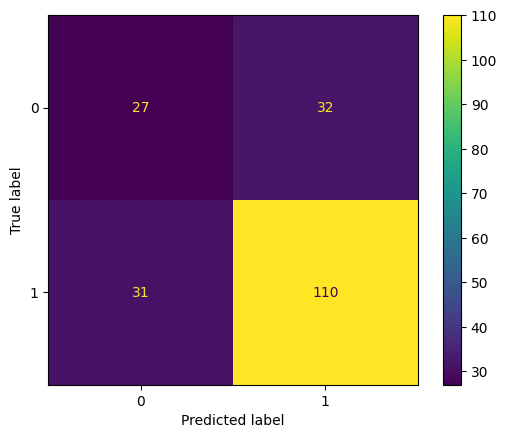

In [79]:
# Confusion matrix without over or under sampling
ConfusionMatrixDisplay.from_estimator(model_over, X_test, y_test);

**Saving the model**

In [82]:
# Saving the model`
with open("decisiontree_classifier.pkl", "wb") as f:
    pickle.dump(model_over, f)

*Since the model is not a good model for prediction, we build another advanced model as shown below*

**     **

**Randomforest Classifier**

**Iteration of random forest classifier**

In [83]:
# Fit on `X_train_over`, `y_train_over`
clf = Pipeline([
    ('feature_selection', FunctionTransformer(func=selected_var, validate=False)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', RandomForestClassifier(random_state=42))
])

model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('feature_selection',
                 FunctionTransformer(func=<function selected_var at 0x7d20bcd77b50>)),
                ('imputer', SimpleImputer()),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [84]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.85714286 0.82589286 0.83035714 0.89686099 0.87892377]


In [85]:
params = {
    "classifier__n_estimators": range(25, 100, 25),
    "classifier__max_depth": range(10, 50, 10)
}

In [86]:
model_over_2 = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [87]:
# Train model
model_over_2.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        FunctionTransformer(func=<function selected_var at 0x7d20bcd77b50>)),
                                       ('imputer', SimpleImputer()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(10, 50, 10),
                         'classifier__n_estimators': range(25, 100, 25)},
             verbose=1)

**Model Evaluation**

In [88]:
acc_train = model_over_2.score(X_train, y_train)
acc_test = model_over_2.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9988
Test Accuracy: 0.81


**COMMUNICATION OF RESULTS**

*Confusion matrix*

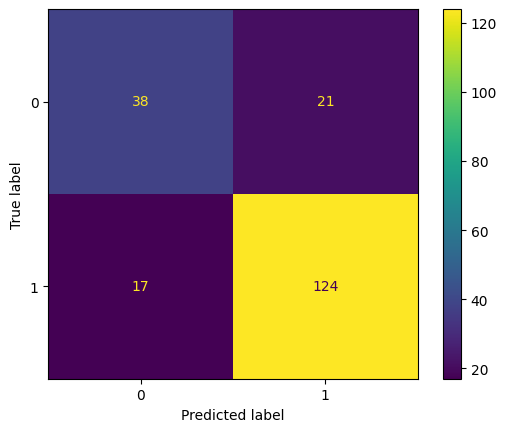

In [89]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_over_2, X_test, y_test);

**The model is a good model but still if the company use it for making decision, the company is going risk money on many (17) clients who may not pay back the loan. Because of this, we need to build a better model**

** **

**Saving the model**

In [90]:
# Save model
with open("random_forest_classifier.pkl", "wb") as f:
    pickle.dump(model_over_2, f)

** **

** **

**GRADIENT BOOSTINGCLASSIFICATION**

**Iteration of gradient boosting classifier**

In [91]:
clf = make_pipeline(
    FunctionTransformer(func=selected_var, validate=False),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42)
)

In [95]:
# Setting hyperparameters
params = {
    "gradientboostingclassifier__n_estimators": range(20, 100, 5),
    "gradientboostingclassifier__max_depth": range(2, 15)
}

In [96]:
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

In [97]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 208 candidates, totalling 1040 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function selected_var at 0x7d20bcd77b50>)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 15),
                         'gradientboostingclassifier__n_estimators': range(20, 100, 5)},
             verbose=1)

In [99]:
# Extract best hyperparameters
best_estimator = model.best_estimator_

** **

**Model Evaluation**

In [100]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.955
Validation Accuracy: 0.8


**   **

**Comunication of Results**

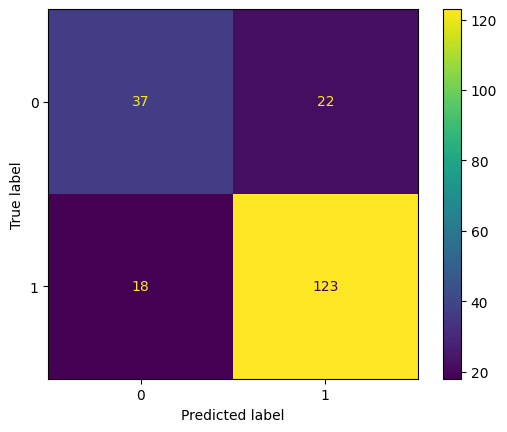

In [101]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

**Since the model predicts well, with few true false  (1, 0), therefore the company makes little loss**

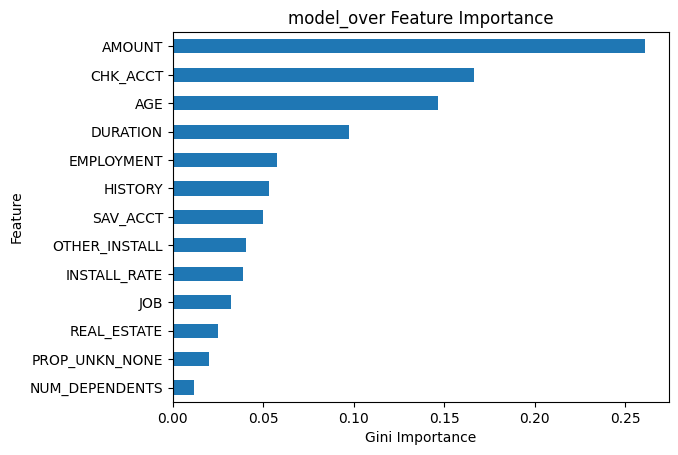

In [102]:
# Get importances
importances = best_estimator.named_steps["gradientboostingclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index=selected_var(df).columns).sort_values()

# Plot series
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");


** **

**Saving the model**

In [103]:
# Saving the model`
with open("gradient_booster.pkl", "wb") as f:
    pickle.dump(model_over, f)

** **

**Predicting the outcome**

In [122]:
# Create the prediction function
def predict_with_user_input():
    # Prompt user for input
    AMOUNT = int(input("Credit amount: "))
    CHK_ACCT = int(input("Account Status: "))
    AGE = int(input("Age: "))
    SAV_ACCT = int(input("Average balance in savings account: "))
    DURATION = int(input("Duration: "))
    HISTORY = int(input("History: "))
    EMPLOYMENT = int(input("Period since employment: "))
    OTHER_INSTALL = int(input("Other Installment plan credit: "))
    INSTALL_RATE = int(input("Installment rate as percentage of disposable income: "))
    PROP_UNKN_NONE = int(input("Applicant owns no property: "))
    NUM_DEPENDENTS = int(input("Number of people for whom liable to provide maintenance: "))
    REAL_ESTATE = int(input("Borrowing for Real Estate: "))
    JOB = int(input("Borrowing for Job: "))

    # Preprocess input (convert to NumPy array)
    user_input = pd.DataFrame({"AMOUNT":[AMOUNT] , "CHK_ACCT": [CHK_ACCT], "AGE": [AGE],
              "SAV_ACCT": [SAV_ACCT], "DURATION": [DURATION], "HISTORY": [HISTORY],
              "EMPLOYMENT": [EMPLOYMENT], "OTHER_INSTALL": [OTHER_INSTALL], "INSTALL_RATE": [INSTALL_RATE],
              "PROP_UNKN_NONE": [PROP_UNKN_NONE],"NUM_DEPENDENTS": [NUM_DEPENDENTS], "REAL_ESTATE": [REAL_ESTATE], "JOB": [JOB]})

    # Make prediction
    with open("random_forest_classifier.pkl", "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    prediction = model.predict(user_input)

    prediction_dictionary = {'prediction': prediction, 'user_input':user_input}

    return print(prediction_dictionary['prediction'][0])

In [123]:
prediction = predict_with_user_input()

Credit amount: 1000
Account Status: 1
Age: 23
Average balance in savings account: 100
Duration: 5
History: 2
Period since employment: 1
Other Installment plan credit: 1
Installment rate as percentage of disposable income: 1
Applicant owns no property: 1
Number of people for whom liable to provide maintenance: 1
Borrowing for Real Estate: 1
Borrowing for Job: 1
1


** **

**MODEL DEPLOYMENT**

In [124]:
app = Dash(__name__)

In [125]:
app.layout = html.Div([
    html.H1("GNU GRIB CREDIT SYSTEM"),
    dcc.Graph(
        id='doughnut_chart_employ_since',
        figure=doughnut_chart_employ_since()
    ),
    dcc.Graph(
        id='histogram_age',
        figure=histogram_age()
    ),
    dcc.Graph(
        id='horizontal_chart_status',
        figure=horizontal_chart_status()
    ),
    html.H1("CREDIT WORTHINESS PREDICTOR"),
    html.Div([
        html.Label("Credit amount:"),
        dcc.Input(id="amount-input", type="number", value=1000),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Account Status:"),
        dcc.Input(id="chk-acct-input", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
       html.Label("Age:"),
       dcc.Input(id="Age", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Average balance in savings account:"),
        dcc.Input(id="savings-account", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Duration:"),
        dcc.Input(id="Duration", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("History:"),
        dcc.Input(id="History", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Period since employment:"),
        dcc.Input(id="employment", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Other Installment plan credit:"),
        dcc.Input(id="Other-Installment-plan-credit", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Installment rate as percentage of disposable income:"),
        dcc.Input(id="disposable-income", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Applicant owns no property:"),
        dcc.Input(id="Applicant-owns-no-property", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Number of people for whom liable to provide maintenance:"),
        dcc.Input(id="provide-maintenance", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Borrowing for Real Estate:"),
        dcc.Input(id="Borrowing-for-Real-Estate", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Label("Borrowing for Job:"),
        dcc.Input(id="Borrowing-for-Job", type="number", value=0),
    ], style={'margin-bottom': '10px'}),

    html.Div([
        html.Button("Predict", id="predict-button"),
    ], style={'margin-bottom': '10px'}),

    html.Div(id="prediction-output-worth"),

])

In [126]:
# Create the prediction function
def predict_with_input(user_input):
    # Load the trained model
    with open("random_forest_classifier.pkl", "rb") as f:
        model = pickle.load(f)
    prediction = model.predict(user_input)
    return prediction[0]

In [127]:
@app.callback(
    Output("prediction-output-worth", "children"),
    Input("predict-button", "n_clicks"),
    [
        Input("amount-input", "value"),
        Input("chk-acct-input", "value"),
        Input("Age", "value"),
        Input("savings-account", "value"),
        Input("Duration", "value"),
        Input("History", "value"),
        Input("employment", "value"),
        Input("Other-Installment-plan-credit", "value"),
        Input("disposable-income", "value"),
        Input("Applicant-owns-no-property", "value"),
        Input("provide-maintenance", "value"),
        Input("Borrowing-for-Real-Estate", "value"),
        Input("Borrowing-for-Job", "value"),
    ],
)
def update_prediction(n_clicks, amount, chk_acct, age, sav_acct, duration, history, employment, other_install, install_rate,
                     prop_unkn_none, num_dependents, real_estate, job):
    if n_clicks is None:
        return ""

    # Preprocess input (convert to DataFrame)
    user_input = pd.DataFrame({
        "AMOUNT": [amount],
        "CHK_ACCT": [chk_acct],
        "AGE": [age],
        "SAV_ACCT": [sav_acct],
        "DURATION": [duration],
        "HISTORY": [history],
        "EMPLOYMENT": [employment],
        "OTHER_INSTALL": [other_install],
        "INSTALL_RATE": [install_rate],
        "PROP_UNKN_NONE": [prop_unkn_none],
        "NUM_DEPENDENTS": [num_dependents],
        "REAL_ESTATE": [real_estate],
        "JOB": [job]
    })

    try:
        trigger_id = dash.callback_context.triggered[0]["prop_id"]
        if trigger_id == "predict-button.n_clicks":
            prediction = predict_with_input(user_input)
            return f"Predicted Credit Outcome: {prediction}"
    except dash.exceptions.CallbackException:
        pass

    return ""

In [128]:
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>